## Example

In this simple example, we load an image, pre-process it, and classify it with a pretrained EfficientNet.

In [ ]:
import json
from PIL import Image

import torch
from torchvision import transforms
from torch import nn
from torch.nn import functional as F

from efficientnet_pytorch import EfficientNet

In [5]:
model_name = 'efficientnet-b0'
image_size = EfficientNet.get_image_size(model_name) # 224

In [6]:
# Open image
img = Image.open('img.jpg')
# img

In [7]:
# Preprocess image
tfms = transforms.Compose([transforms.Resize(image_size), transforms.CenterCrop(image_size), 
                           transforms.ToTensor(),
                           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
img = tfms(img).unsqueeze(0)

In [8]:
# Load class names
labels_map = json.load(open('labels_map.txt'))
labels_map = [labels_map[str(i)] for i in range(1000)]
print(len(labels_map))

1000


In [9]:
def print_model(module, name="model", depth=0):
    if len(list(module.named_children())) == 0:
        print(f"{' ' * depth} {name}: {module}")
    else:
        print(f"{' ' * depth} {name}: {type(module)}")

    for child_name, child_module in module.named_children():
        if isinstance(module, torch.nn.Sequential):
            child_name = f"{name}[{child_name}]"
        else:
            child_name = f"{name}.{child_name}"
        print_model(child_module, child_name, depth + 1)
    

In [10]:
model = EfficientNet.from_pretrained(model_name)
endpoints = model.extract_endpoints(img)
image_tensors = []
image_tensors.extend(img.flatten().shape)
for endp in endpoints:
    image_tensors.extend(endpoints[endp].flatten().shape)


Loaded pretrained weights for efficientnet-b0


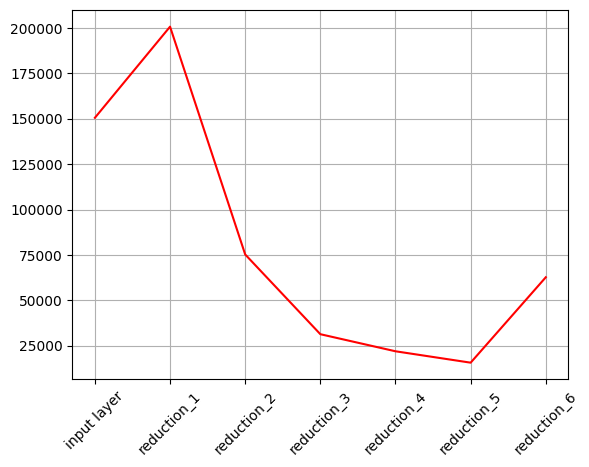

In [11]:
import matplotlib.pyplot as plt 
names = ["input layer"]
names.extend(list(endpoints.keys()))
plt.plot(names, image_tensors, color='red')
plt.xticks(rotation=45)
plt.grid()
plt.show()

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b1
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b3
Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b5
Loaded pretrained weights for efficientnet-b6
Loaded pretrained weights for efficientnet-b7


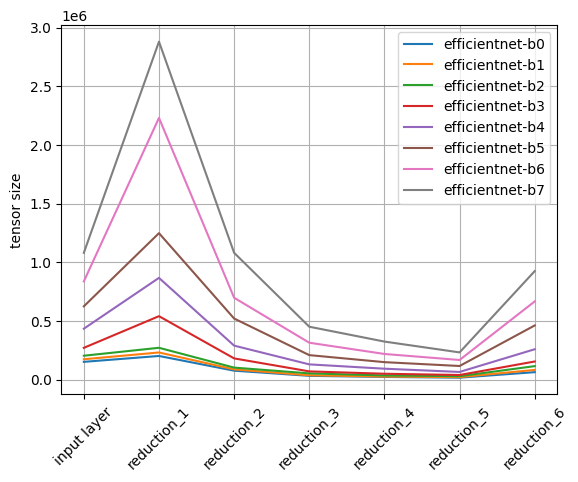

In [19]:
model_names = ['efficientnet-b0','efficientnet-b1','efficientnet-b2','efficientnet-b3','efficientnet-b4','efficientnet-b5','efficientnet-b6','efficientnet-b7']
# Open image
ori_img = Image.open('img.jpg')
# img
# Preprocess image
model_tensor = {}
for m in model_names:
    image_tensors = []
    image_size = EfficientNet.get_image_size(m)  
    model = EfficientNet.from_pretrained(m)
    tfms = transforms.Compose([transforms.Resize(image_size), transforms.CenterCrop(image_size), 
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
    img = tfms(ori_img).unsqueeze(0)
    image_tensors = []
    endpoints = model.extract_endpoints(img)
    image_tensors.extend(img.flatten().shape)
    for endp in endpoints:
#         print(endp,":",teacher_endpoints[endp].shape)
        image_tensors.extend(endpoints[endp].flatten().shape)
    model_tensor[m] = image_tensors
names = ["input layer"]
names.extend(list(endpoints.keys()))
import matplotlib.pyplot as plt
import numpy as np

d = []
fig, ax = plt.subplots() # 创建图实例
for i in model_tensor:
    t = model_tensor[i]
    ax.plot(names, t, label=i) # 作y1 = x 图，并标记此线名为linear
    ax.set_ylabel('tensor size') #设置y轴名称 y label
#     ax.set_title('Simple Plot') #设置图名为Simple Plot
    ax.legend() #自动检测要在图例中显示的元素，并且显示
    plt.xticks(rotation=45)
plt.grid()
# plt.savefig("reduction.png")
plt.show() #图形可视化

In [12]:
# Classify with EfficientNet
model.eval() #dont activate "Batch Normalization and Dropout"
with torch.no_grad():#停止梯度的更新 Stop gradient renew 
    logits = model(img)
preds = torch.topk(logits, k=5).indices.squeeze(0).tolist()
# print(preds)
print('-----')
for idx in preds:
    label = labels_map[idx]
    prob = torch.softmax(logits, dim=1)[0, idx].item()
    print('{} {:<75} ({:.2f}%)'.format(idx, label, prob*100))

-----
388 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca           (82.72%)
294 brown bear, bruin, Ursus arctos                                             (0.67%)
387 lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens         (0.60%)
296 ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus                 (0.47%)
279 Arctic fox, white fox, Alopex lagopus                                       (0.35%)


In [18]:
class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class MemoryEfficientSwish(nn.Module):
    def forward(self, x):
        return SwishImplementation.apply(x)
        
class Headmodel(nn.Module):
    def __init__(self,student_efficientnet=EfficientNet.from_pretrained('efficientnet-b0')):
        super().__init__()
        self._conv_stem = student_efficientnet._conv_stem
        self._bn0 = student_efficientnet._bn0
        self._swish = MemoryEfficientSwish()
        self._blocks = student_efficientnet._blocks[:2]
        self.connect = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=1, stride=1, padding=10)
        
    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export).

        Args:
            memory_efficient (bool): Whether to use memory-efficient version of swish.
        """
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()
        for block in self._blocks:
            block.set_swish(memory_efficient)
            
    def extract_features(self, inputs):
        """use convolution layer to extract feature .

        Args:
            inputs (tensor): Input tensor.

        Returns:
            Output of the final convolution
            layer in the efficientnet model.
        """
        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
#             print(idx, block)
#             print(block.forward(x).shape)
            drop_connect_rate = 0.2
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)  # scale drop connect_rate
            x = block(x, drop_connect_rate=drop_connect_rate)
        
        x = self.connect(x)
        x = x.repeat(1,1,2,2)
        x = x[:,:,:150,:150]
        return x
    
    def forward(self, inputs):
        """EfficientNet's forward function.
           Calls extract_features to extract features, applies final linear layer, and returns logits.

        Args:
            inputs (tensor): Input tensor.

        Returns:
            Output of this model after processing.
        """
        # Convolution layers
        x = self.extract_features(inputs)
        # Pooling and final linear layer
        x = self._avg_pooling(x)
        if self._global_params.include_top:
            x = x.flatten(start_dim=1)
            x = self._dropout(x)
            x = self._fc(x)
        return x
    
net = Headmodel()
print(net)
head_output = net.extract_features(img)
print(head_output.shape)

Loaded pretrained weights for efficientnet-b0
Headmodel(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_swish): MemoryEfficientSwish()
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      

In [16]:
student_output = endpoints['reduction_2']

torch.all(head_output.eq(student_output))

tensor(False)